In [9]:
from policyengine_uk import Microsimulation
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
import geopandas as gpd

In [2]:
baseline = Microsimulation()
baseline_income = baseline.calculate("real_household_net_income", period=2024)
baseline_people = baseline.calculate("people", map_to = "household", period=2024)

In [3]:
# Load the direct mapping matrix
mapping_matrix = pd.read_csv("mapping_2010_to_LAD2024.csv")
mapping_matrix = mapping_matrix.set_index(mapping_matrix.columns[0])

# Load weights
with h5py.File("../constituencies/weights.h5", "r") as f:
    weights = f["weight"][:]

# Apply mapping to weights
weights_lad = mapping_matrix.T.dot(weights)

# Calculate income and population for LADs
income_lad = np.dot(weights_lad, baseline_income.values)
population_lad = np.dot(weights_lad, baseline_people.values)
per_capita_lad = income_lad / population_lad

# Create final dataframe
lad_data = pd.DataFrame({
    'LAD24CD': mapping_matrix.columns,
    'income': per_capita_lad
})

# Add LAD names
constituency_lad = pd.read_csv("Constituency_to_LAD(2024).csv", 
                             usecols=['LAD24CD', 'LAD24NM'])
lad_data = lad_data.merge(
    constituency_lad[['LAD24CD', 'LAD24NM']].drop_duplicates(),
    on='LAD24CD',
    how='left'
)

lad_data.head()

,LAD24CD,income,LAD24NM
0,E06000001,14037.783074,Hartlepool
1,E06000002,14634.484076,Middlesbrough
2,E06000003,14986.287514,Redcar and Cleveland
3,E06000004,15046.469389,Stockton-on-Tees
4,E06000005,14985.379352,Darlington


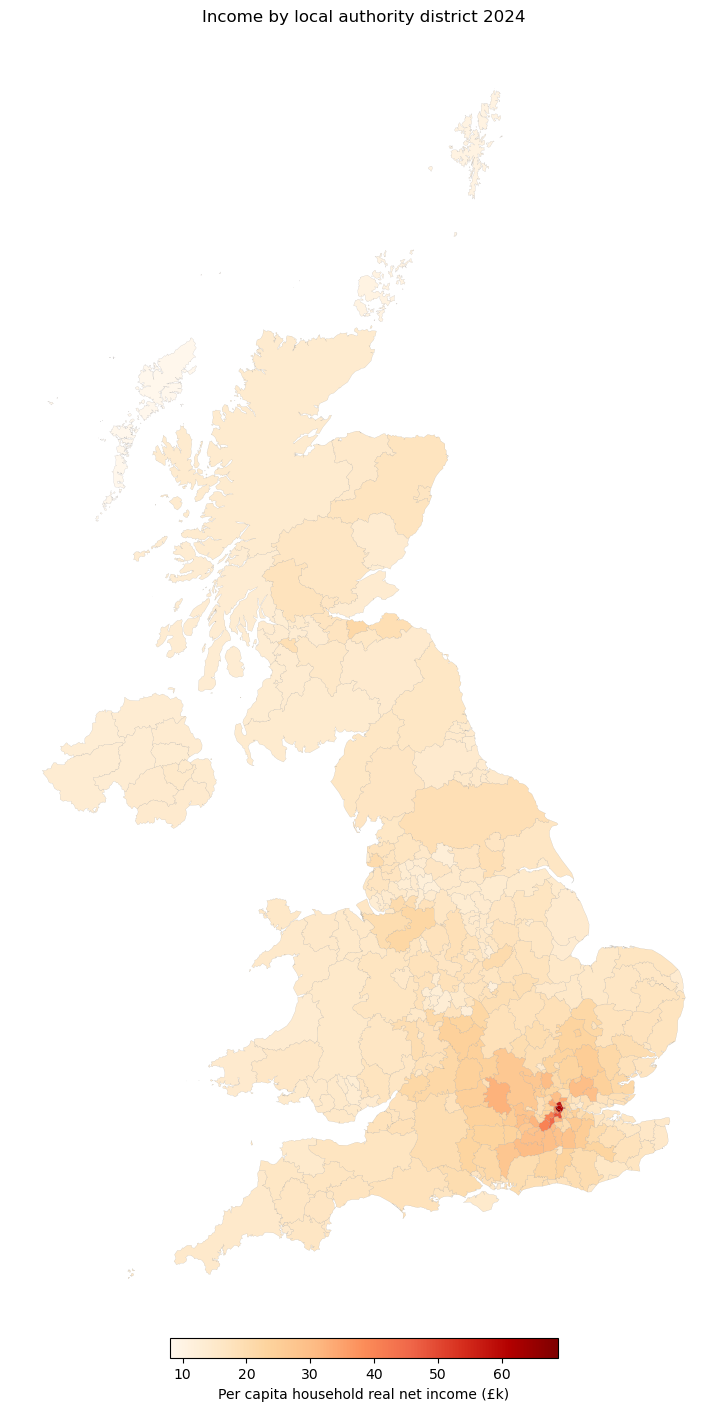

In [10]:
# Path to the zip file
zip_file_path = "Local_Authority_2024_Boundaries.zip"

# Extract the zip file
extracted_folder = "extracted_shapefile"
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)

# Find the .shp file in the extracted folder
shapefile_path = None
for root, dirs, files in os.walk(extracted_folder):
    for file in files:
        if file.endswith(".shp"):
            shapefile_path = os.path.join(root, file)
            
if shapefile_path:
    # Load the shapefile
    gdf = gpd.read_file(shapefile_path)
    
    # Convert income to thousands for better visualization
    lad_data_copy = lad_data.copy()  # Using lad_data from our previous calculation
    lad_data_copy['income'] = lad_data_copy['income'] / 1000

    # Merge GeoDataFrame with our calculated income data
    merged_gdf = gdf.merge(lad_data_copy, on="LAD24CD", how="left")

    # Plot the heatmap
    fig, ax = plt.subplots(1, 1, figsize=(10, 20))
    merged_gdf.plot(
        column="income", 
        cmap="OrRd", 
        linewidth=0.08, 
        ax=ax, 
        edgecolor="0.5", 
        legend=True,
        legend_kwds={
            'orientation': 'horizontal',
            'shrink': 0.5,
            'pad': 0.0,
            'label': 'Per capita household real net income (£k)'
        }
    )
    ax.axis('off')
    plt.title("Income by local authority district 2024")
    plt.show()
    
    # Optional: Save the plot
    # plt.savefig('lad_income_map_2024.png', dpi=300, bbox_inches='tight')
else:
    print("No shapefile (.shp) found in the ZIP archive.")